In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the final processed dataset
file_path = "../data/scaled_flood_data.csv"
df = pd.read_csv(file_path)

# Define features (X) - Remove "Effect" Variables
features_to_remove = ['Flood Occurred', 'Damage to Crops', 'Damage to Houses', 
                      'Area affected in (m.ha)', 'Population affected in (million)']

X = df.drop(columns=features_to_remove)  # Keep only predictive features
y = df['Flood Occurred']  # Target (0 = No, 1 = Yes)

# Perform train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display dataset shapes
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")

Training Set: (26280, 8), Testing Set: (6571, 8)


In [49]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Load balanced dataset
file_path = "../data/scaled_flood_data.csv"
df = pd.read_csv(file_path)

# Remove post-flood effect variables & low-importance features
features_to_remove = ['Flood Occurred', 'Damage to Crops', 'Damage to Houses', 
                      'Area affected in (m.ha)', 'Population affected in (million)', 
                      'Flood Risk', 'River']  # Remove River (Low Importance)
X = df.drop(columns=features_to_remove)
y = df['Flood Occurred']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### **1️⃣ Train a Simpler Random Forest Model**
rf_model = RandomForestClassifier(
    n_estimators=30,  # Reduce number of trees
    max_depth=4,  # Limit tree depth
    min_samples_split=15,  # Increase min samples per split
    min_samples_leaf=10,  # Increase min samples per leaf
    class_weight="balanced",  # Handle imbalance
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predict & Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Reduced Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nReduced Random Forest Classification Report:\n", report_rf)
print(f"\nCross-Validation Accuracy: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

### **2️⃣ Train a Simpler XGBoost Model**
xgb_model = xgb.XGBClassifier(
    n_estimators=50,  # Reduce number of trees
    max_depth=4,  # Reduce tree complexity
    learning_rate=0.05,  # Slow down learning
    subsample=0.7,  # Use 70% of data per tree (randomness)
    colsample_bytree=0.7,  # Use 70% of features per tree
    scale_pos_weight=1.5,  # Improve recall for Flood cases (1)
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict & Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"\nReduced XGBoost Accuracy: {accuracy_xgb:.4f}")
print("\nReduced XGBoost Classification Report:\n", report_xgb)
print(f"\nCross-Validation Accuracy: {cv_scores_xgb.mean():.4f} ± {cv_scores_xgb.std():.4f}")


Reduced Random Forest Accuracy: 0.8002

Reduced Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.84      3769
           1       0.81      0.69      0.75      2802

    accuracy                           0.80      6571
   macro avg       0.80      0.79      0.79      6571
weighted avg       0.80      0.80      0.80      6571


Cross-Validation Accuracy: 0.8094 ± 0.0032

Reduced XGBoost Accuracy: 0.8121

Reduced XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      3769
           1       0.81      0.73      0.77      2802

    accuracy                           0.81      6571
   macro avg       0.81      0.80      0.81      6571
weighted avg       0.81      0.81      0.81      6571


Cross-Validation Accuracy: 0.8200 ± 0.0051


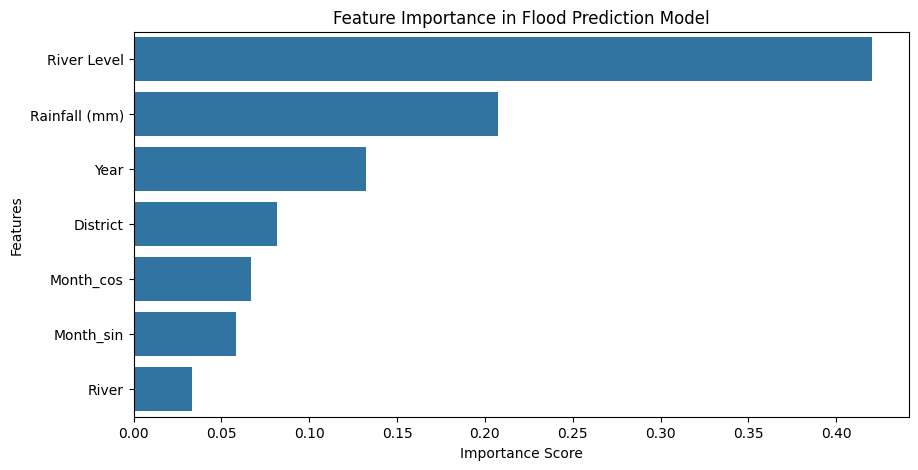


Top Features Influencing Flood Prediction:

         Feature  Importance
3    River Level    0.420123
1  Rainfall (mm)    0.207203
4           Year    0.132286
0       District    0.081570
6      Month_cos    0.067031
5      Month_sin    0.058488
2          River    0.033299


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Load the expanded dataset
file_path = "../data/scaled_flood_data.csv"
df = pd.read_csv(file_path)

# Remove post-flood effect variables
features_to_remove = ['Flood Occurred', 'Damage to Crops', 'Damage to Houses', 
                      'Area affected in (m.ha)', 'Population affected in (million)', 
                      'Flood Risk']
X = df.drop(columns=features_to_remove)
y = df['Flood Occurred']

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
importances = rf_model.feature_importances_
feature_names = X.columns

# Convert to DataFrame and sort
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feat_importance_df['Importance'], y=feat_importance_df['Feature'])
plt.title("Feature Importance in Flood Prediction Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Print top features
print("\nTop Features Influencing Flood Prediction:\n")
print(feat_importance_df.head(10))

In [51]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# Load the expanded dataset
file_path = "../data/scaled_flood_data.csv"
df = pd.read_csv(file_path)

# Remove post-flood effect variables
features_to_remove = ['Flood Occurred', 'Damage to Crops', 'Damage to Houses', 
                      'Area affected in (m.ha)', 'Population affected in (million)', 
                      'Flood Risk']
X = df.drop(columns=features_to_remove)
y = df['Flood Occurred']

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,      # Number of trees
    max_depth=5,           # Tree depth (avoids overfitting)
    learning_rate=0.1,     # How much each tree contributes
    subsample=0.8,         # Use 80% of data per tree
    colsample_bytree=0.8,  # Use 80% of features per tree
    random_state=42
)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Perform Cross-Validation (5-Fold)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

# Print results
print(f"XGBoost Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", report)
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


XGBoost Accuracy: 0.8341

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      3769
           1       0.86      0.73      0.79      2802

    accuracy                           0.83      6571
   macro avg       0.84      0.82      0.83      6571
weighted avg       0.84      0.83      0.83      6571


Cross-Validation Accuracy: 0.8416 ± 0.0056
